### Team Members

*   Ian Jenatz (isj273)
*   Arnav Vats (av38999)
*   Haiyung (Jeff) Wang (hw22882)
*   Mayank Tibrewal (mt39697)
*   Harrison Schick (hs33786)

---
# Steam Scope

 A Data-Driven Approach to Video Game Analysis

---

## Scraper

In [16]:
runScraper = False

if runScraper:
  import requests
  from bs4 import BeautifulSoup
  import pandas as pd
  import re

  '''
  Scraper general idea:
  First, we need the top 100 games and their ids. Create a scraper to get the top 100 games and their ideas into a list.
  Then, create a for loop for every game_id. In the loop, scrape each game's review page (100 reviews each so 10,000 total).
  Add all fields into an excel with columns: game_id, game_name, player_username, review_content
  '''

  session = requests.Session()

  # Game_ID Scraping:
  top_games_url = "https://steam250.com/top250"

  page = session.get(top_games_url)
  soup = BeautifulSoup(page.content.decode('utf-8', 'ignore'), 'lxml')
  ranking = soup.find('div', attrs={'class':'col1 main ranking'})
  game_links = ranking.select('a[href*="club.steam250.com/app"]')

  num_games = 0
  links_dict = {}
  for element in game_links:
      if element.find('img'): continue
      # print(element)
      link = element['href']
      # print(link)
      sub = link.split('/')
      game_name = element.text.strip()
      links_dict[game_name] = sub[-1]
      num_games += 1
      if num_games >= 100: break

  # Game tags Scraping:
  games_with_tags = {game: [game_id, []] for game, game_id in links_dict.items()}
  for game_name, game_info in games_with_tags.items():
      game_id = game_info[0]
      game_page_url = f'https://store.steampowered.com/app/{game_id}'
      page = session.get(game_page_url)
      soup = BeautifulSoup(page.content.decode('utf-8', 'ignore'), 'lxml')
      tags = soup.find_all("a", {"class": "app_tag"})

      cleaned_tags = [re.sub(r"[\n\t\s]*", "", tag.get_text()) for tag in tags]
      game_info[1] = cleaned_tags
      # print(cleaned_tags)

  n = 1
  for i, j in games_with_tags.items():
      print(n, i, j)
      n += 1

In [17]:
if runScraper:
  %pip install selenium
  !apt-get -q update
  !apt install -yq chromium-chromedriver/
  %cp /usr/lib/chromium-browser/chromedriver /usr/bin

  import sys
  from time import sleep
  from datetime import datetime
  sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
  from selenium import webdriver
  from selenium.webdriver.common.by import By
  #WebDriver is a browser automation framework that works with open source APIs.
  #The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
  chrome_options = webdriver.ChromeOptions()
  #headless means running chrome with chrome.exe
  chrome_options.add_argument('--headless')

  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome(options=chrome_options)


  # Review Scraping:
  num = 1
  main_review_list = []
  missed_games = []
  for game_name, game_info in games_with_tags.items():
      game_id = game_info[0]
      print(num, game_name, game_id)
      url = f'https://steamcommunity.com/app/{game_id}/reviews/?browsefilter=mostrecent'
      driver.maximize_window()
      driver.get(url)

      last_position = driver.execute_script("return window.pageYOffset;")
      reviews = []
      review_ids = set()
      comments = 0
      running = True

      while running and comments < 100:
          cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

          if not cards:
              button = driver.find_element(By.XPATH, '//*[@id="responsive_page_template_content"]/div/div/div[2]/button[1]')
              if button:
                  button.click()
                  sleep(1)
                  continue

          for card in cards[-20:]:  # only the tail end are new cards

              # gamer profile url
              profile_url = card.find_element('xpath', './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')

              # steam id
              steam_id = profile_url.split('/')[-2]

              # check to see if I've already collected this review
              if steam_id in review_ids:
                  continue
              else:
                  review_ids.add(steam_id)

              # username
              user_name = card.find_element('xpath', './/div[@class="apphub_friend_block"]/div/a[2]').text

              # # date posted
              date_posted = card.find_element('xpath', './/div[@class="apphub_CardTextContent"]/div').text

              # review content
              review_content = card.find_element('xpath', './/div[@class="apphub_CardTextContent"]').text.replace(date_posted,'').strip()

              # # review length
              # review_length = len(review_content.replace(' ', ''))

              # recommendation
              thumb_text = card.find_element('xpath', './/div[@class="reviewInfo"]/div[2]').text

              # # amount of play hours
              # play_hours = card.find_element('xpath', './/div[@class="reviewInfo"]/div[3]').text
              # play_hours

              # save review
              # review = (steam_id, profile_url, review_content, thumb_text, review_length, play_hours, date_posted)
              review = (game_name, game_id, steam_id, review_content, thumb_text, game_info[1])
              reviews.append(review)
              comments += 1

          # attempt to scroll down thrice.. then break
          scroll_attempt = 0
          while True:
              driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
              sleep(0.5)
              curr_position = driver.execute_script("return window.pageYOffset;")

              if curr_position == last_position:
                  scroll_attempt += 1
                  sleep(0.5)

                  if scroll_attempt >= 5:
                      running = False
                      print(f'Failed to retrieve 100 comments. Amount of comments: {comments}')
                      if comments == 0:
                          missed_games.append(game_name)
                      break
              else:
                  last_position = curr_position
                  break  # continue scraping the results

      main_review_list.extend(reviews)
      num += 1

  df = pd.DataFrame(main_review_list)
  df.columns = ['game_name', 'game_id', 'steam_id', 'review_content', 'recommendation', 'genre_tags']

  df.to_csv('steam_games_reviews.csv', index=False, encoding='utf-8-sig')

## Genre / Feature Frequencies

#### Zipf's Law

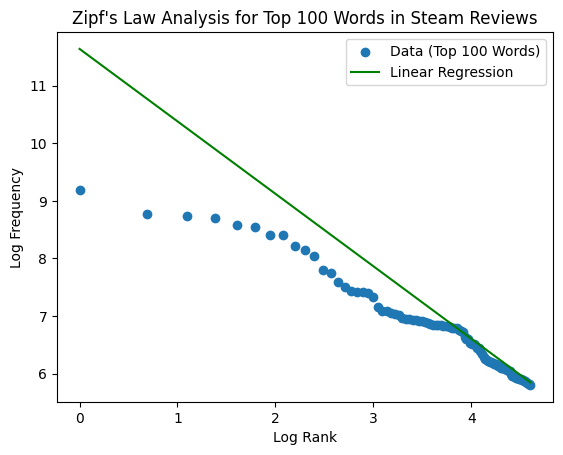

In [18]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_1samp

# Define the function to count word frequencies
def count_word_frequencies(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return Counter(words)

# Load the Steam data
steam_data = pd.read_csv('steam_games_reviews.csv')

# Combine all review contents into a single string
all_reviews = ' '.join(steam_data['review_content'].dropna().astype(str))

# Count word frequencies (excluding stopwords)
word_frequencies = count_word_frequencies(all_reviews)

# Sort word frequencies by frequency in descending order
sorted_word_frequencies = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True))

# Create ranks for words based on their frequencies
ranks = np.arange(1, len(sorted_word_frequencies) + 1)

# Convert to NumPy arrays and add a small constant to avoid log(0)
frequencies = np.array(list(sorted_word_frequencies.values())) + 1e-10

# Perform linear regression on the log-transformed ranks and frequencies
slope, intercept, r_value, p_value, std_err = linregress(np.log(ranks), np.log(frequencies))

# Negating the slope to match the expected negative relationship in Zipf's law
alpha = -slope

# Perform a t-test to check if alpha is significantly different from -1
t_statistic, t_test_p_value = ttest_1samp(np.log(frequencies) - np.log(ranks) * slope, -1)

# Interpretation based on t-test
if t_test_p_value < 0.05:
    interpretation = "\nAlpha significantly differs from -1 (p-value: {}). Data may not follow Zipf's law.".format(t_test_p_value)
else:
    interpretation = "\nAlpha does not significantly differ from -1 (p-value: {}). Data may follow Zipf's law.".format(t_test_p_value)

# Print the coefficient of the model
coefficient_output = "Coefficient (alpha): {}".format(alpha)

# Prepare data for visualization
top_frequencies = frequencies[:100]
top_ranks = ranks[:100]

# Visualization will be done using matplotlib, plotting the top 100 words
plt.scatter(np.log(top_ranks), np.log(top_frequencies), label='Data (Top 100 Words)')
plt.plot(np.log(top_ranks), slope * np.log(top_ranks) + intercept, color='green', label='Linear Regression')
plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')
plt.title("Zipf's Law Analysis for Top 100 Words in Steam Reviews")
plt.legend()
plt.show()


#### Calculating most frquently used words

In [19]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
from tabulate import tabulate

# Download nltk stopwords and punkt tokenizer
nltk.download("stopwords")
nltk.download('punkt')

# Load the data from the Steam reviews Excel file
steam_data = pd.read_csv('/content/steam_games_reviews.csv')

# Set up English stopwords
stop_words = set(stopwords.words("english"))

# Extract review content
reviews = steam_data['review_content'].dropna().astype(str).str.lower()

# Function to tokenize and filter the reviews
def process_reviews(reviews):
    # Combine all reviews into one large string
    all_reviews = ' '.join(reviews)

    # Tokenize the text
    words = nltk.word_tokenize(all_reviews)

    # Filter out stopwords and punctuation
    filtered_words = [word for word in words if word not in stop_words and word.isalnum()]

    return filtered_words

# Process the reviews
filtered_words = process_reviews(reviews)

# Count the frequency of each word
word_freq = Counter(filtered_words)

# Convert to a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

# Sort by frequency in descending order and take the top 10
top_words = word_freq_df.sort_values(by='Frequency', ascending=False)

# Save to a CSV file
top_words.to_csv('/content/top_words_steam_reviews.csv', index=False)

# Pretty print the top ten words
top_ten_pretty_table = tabulate(top_words.head(10), headers='keys', tablefmt='fancy_grid')

# Display the top ten words with highest frequencies
print(top_ten_pretty_table)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


╒══════╤════════╤═════════════╕
│      │ Word   │   Frequency │
╞══════╪════════╪═════════════╡
│    3 │ game   │        6184 │
├──────┼────────┼─────────────┤
│   14 │ good   │        1655 │
├──────┼────────┼─────────────┤
│    2 │ love   │        1627 │
├──────┼────────┼─────────────┤
│   15 │ fun    │        1195 │
├──────┼────────┼─────────────┤
│  154 │ like   │        1101 │
├──────┼────────┼─────────────┤
│  374 │ review │        1025 │
├──────┼────────┼─────────────┤
│   16 │ play   │         990 │
├──────┼────────┼─────────────┤
│  151 │ one    │         963 │
├──────┼────────┼─────────────┤
│ 3022 │ early  │         944 │
├──────┼────────┼─────────────┤
│ 1015 │ access │         926 │
╘══════╧════════╧═════════════╛


#### Calculating Most Frequently mentioned Genres and Features


In [20]:
import pandas as pd
import nltk
import string
from tabulate import tabulate
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter
from tabulate import tabulate

# Load the data from the Steam reviews Excel file
steam_data = pd.read_csv('steam_games_reviews.csv')

# Extract review content
reviews = steam_data['review_content'].dropna().astype(str).str.lower()

# load the 'top_genres' file to get the list of top genres.
genre_file_path = 'top_genres.txt'

# Read the genre list from the file
with open(genre_file_path, 'r') as file:
    genres = file.read().splitlines()

genres = [genre.lower() for genre in genres]

def count_top_genre(reviews):
    # Initialize a Counter to hold the frequency of each genre
    genre_frequency = Counter({genre: 0 for genre in genres})

    # Process the reviews and count the occurrences of each genre
    for review in reviews:
        for genre in genres:
            if genre in review:
                genre_frequency[genre] += 1

    return genre_frequency

# Count frequency of top genre occurences in the reviews
top_genre_frequency = count_top_genre(reviews)

# Convert to a DataFrame
genre_freq_df = pd.DataFrame(top_genre_frequency.items(), columns=['Genre', 'Frequency'])

# Sort by frequency in descending order
top_genre_frequency = genre_freq_df.sort_values(by='Frequency', ascending=False)
top_ten_genre_frequency = top_genre_frequency.head(25)

# Save to a CSV file
top_genre_frequency.to_csv('/content/genre_frequencies.csv', index=False)

#Print the top ten genre count
top_ten_genre_frequency = tabulate(top_ten_genre_frequency, headers='keys', tablefmt='fancy_grid')

# Display the top ten genre with highest frequencies
print(top_ten_genre_frequency)


╒═════╤══════════════╤═════════════╕
│     │ Genre        │   Frequency │
╞═════╪══════════════╪═════════════╡
│   8 │ early access │         903 │
├─────┼──────────────┼─────────────┤
│ 358 │ mod          │         680 │
├─────┼──────────────┼─────────────┤
│ 445 │ art          │         626 │
├─────┼──────────────┼─────────────┤
│ 110 │ war          │         600 │
├─────┼──────────────┼─────────────┤
│ 447 │ character    │         321 │
├─────┼──────────────┼─────────────┤
│ 443 │ gameplay     │         294 │
├─────┼──────────────┼─────────────┤
│ 362 │ experience   │         280 │
├─────┼──────────────┼─────────────┤
│ 197 │ soundtrack   │         274 │
├─────┼──────────────┼─────────────┤
│  17 │ puzzle       │         222 │
├─────┼──────────────┼─────────────┤
│  35 │ relaxing     │         216 │
├─────┼──────────────┼─────────────┤
│ 194 │ music        │         211 │
├─────┼──────────────┼─────────────┤
│  25 │ combat       │         194 │
├─────┼──────────────┼─────────────┤
│

## Plotting Lift Ratio Graph (MDS)

#### Create Co-occurrence matrix

In [21]:
top_25_genre = top_genre_frequency['Genre'][:25]
top_25_genre

8      early access
358             mod
445             art
110             war
447       character
443        gameplay
362      experience
197      soundtrack
17           puzzle
35         relaxing
194           music
25           combat
216       beautiful
21             cute
179           short
446        graphics
47         survival
36           horror
30            funny
458           build
444         puzzles
451          design
449              pc
67        difficult
1            action
Name: Genre, dtype: object

In [22]:
# Download nltk stopwords and punkt pack
nltk.download("stopwords")
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

top_25_genre = top_genre_frequency['Genre'][:25]

# Created attribute matrix based on 25 top attributes
words_co_occurrence_matrix = pd.DataFrame(index=top_25_genre, columns=top_25_genre, data=0)

# Check co-occurrence of two words
def check_word_co_occurrence(review, word1, word2, max_separation=False):

    # if word 1 and word 2 both appear in the same review, then return true
    if(word1 in review and word2 in review):
      return True

    # Otherwise return false
    return False

# Get each review message from the games review data frame
for review in steam_data['review_content'].dropna().astype(str).str.lower().to_list():
    review_string = nltk.word_tokenize(review)

    # Remove stop words and punctuation from each message review
    review_words_list = [word.lower() for word in review_string if word.lower() not in stop_words and all(char not in string.punctuation for char in word)]
    review_words_filtered_string = " ".join(review_words_list)
    review_words_final_list = nltk.word_tokenize(review_words_filtered_string)

    for word1 in top_25_genre:
        for word2 in top_25_genre:
            # Ensure we are not comparing a word with itself
            if word1 != word2:
                if check_word_co_occurrence(review_words_final_list, word1, word2):
                    words_co_occurrence_matrix.loc[word1, word2] += 1

# Get the total length of the games review
total_reviews = len(steam_data)

# Calculated the word probabilities
words_probabilities = genre_freq_df.set_index('Genre')['Frequency'] / total_reviews



# Using the co-occurrence matrix, calculate the lift ratio for each pair of words
for word1 in top_25_genre:
    for word2 in top_25_genre:
        if word1 != word2:
            P_A = words_probabilities[word1]
            P_B = words_probabilities[word2]
            P_A_and_B = words_co_occurrence_matrix.loc[word1, word2] / total_reviews

            lift = P_A_and_B / (P_A * P_B)
            words_co_occurrence_matrix.loc[word1, word2] = round(lift, 4)


# Display the lift ratios in the word co-occurence matrix
words_co_occurrence_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Genre,early access,mod,art,war,character,gameplay,experience,soundtrack,puzzle,relaxing,...,graphics,survival,horror,funny,build,puzzles,design,pc,difficult,action
Genre,,,,,,,,,,,,,,,,,,,,,
early access,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
mod,0,0.0000,0.0000,0.0493,0.0000,0.1509,0.2113,0.0000,0.0000,0.0000,...,0.0924,0.0000,0.0000,0.0000,0.0000,0.1088,0.2405,0.4810,0.1222,0.0000
art,0,0.0000,0.0000,0.0268,0.9510,1.3662,1.1476,0.9382,0.4342,0.2975,...,1.0042,0.2060,0.5217,0.6695,0.3518,1.1814,1.8288,0.5225,0.6639,0.6695
war,0,0.0493,0.0268,0.0000,0.0522,0.0570,0.1197,0.0000,0.0000,0.0000,...,0.2095,0.0000,0.0000,0.0000,0.0000,0.4930,0.0000,0.4089,0.0000,0.0000
character,0,0.0000,0.9510,0.0522,0.0000,2.4512,2.1262,1.3723,0.9880,0.2901,...,1.7625,0.0000,0.8139,1.3056,1.1436,2.3039,2.5474,0.7642,0.5179,2.3500
gameplay,0,0.1509,1.3662,0.0570,2.4512,0.0000,5.7425,3.9954,1.0787,0.4752,...,11.9738,4.8246,2.4436,0.7127,2.7469,5.0310,6.9534,6.1190,6.5029,3.1360
experience,0,0.2113,1.1476,0.1197,2.1262,5.7425,0.0000,3.2775,2.2653,1.4967,...,3.5921,2.5329,2.3326,1.7462,2.3598,5.5467,5.2568,3.7966,2.0781,2.9935
soundtrack,0,0.0000,0.9382,0.0000,1.3723,3.9954,3.2775,0.0000,0.6614,0.5098,...,2.9825,0.4706,0.4767,1.0197,0.8038,1.6195,2.0891,0.2984,0.6067,1.5295
puzzle,0,0.0000,0.4342,0.0000,0.9880,1.0787,2.2653,0.6614,0.0000,0.0000,...,2.2653,0.2904,1.1768,0.9439,0.6614,8.9946,3.3151,1.1050,0.3744,1.5102


#### Create MDS Plot

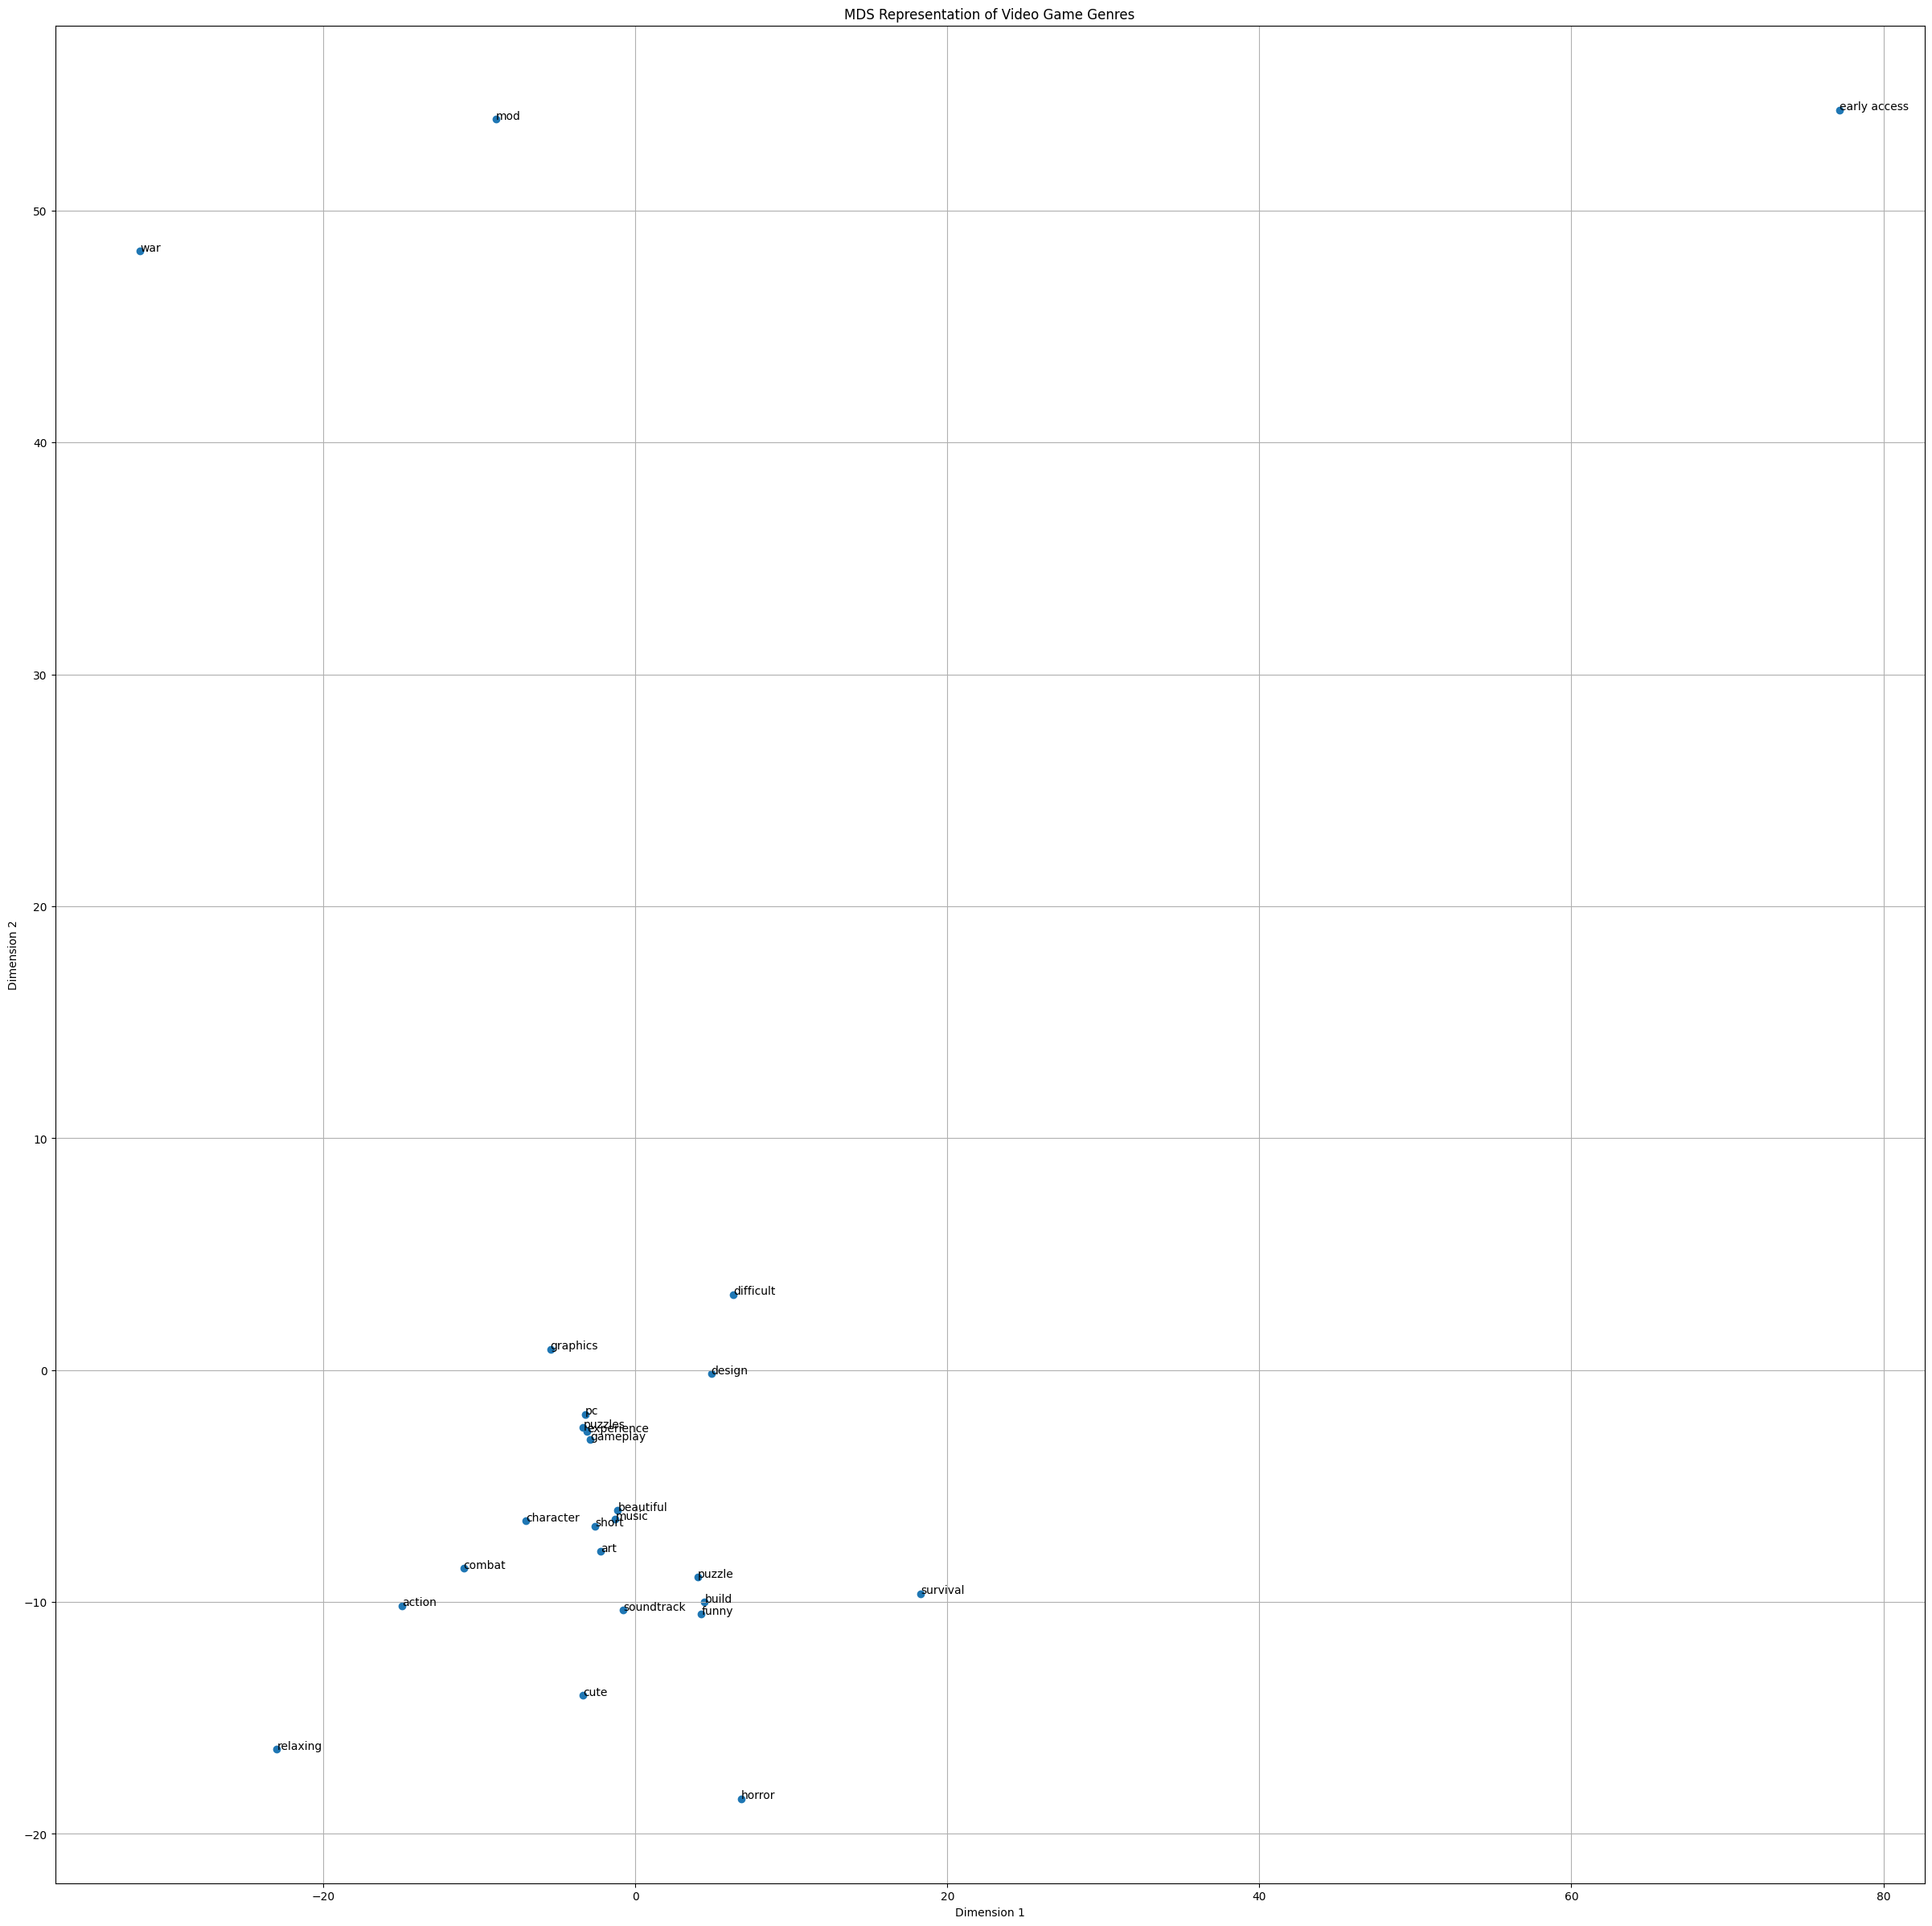

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Plot lift ratio graph so that we could see which three words are likey appear together in the same review
# Make sure exclude zero lift ratio in the graph
def compute_distance(value):
    if value == 0:
        return 100 # Large distance
    return 1 / value

# Calculate the distance on the graph
distance_matrix = words_co_occurrence_matrix.applymap(compute_distance)


# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(distance_matrix)

# Plot the 2D representation
plt.figure(figsize=(30, 30))
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1])

# Annotate the words on the plot
for brand, coords in zip(top_25_genre, mds_coordinates):
    plt.annotate(brand, (coords[0], coords[1]), fontsize=10)

plt.title("MDS Representation of Video Game Genres")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

## Sentiment **Analysis**

In [24]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_sentiment_analysis(reviews_df: pd.DataFrame) -> pd.DataFrame:
    """
    - This function initializes the VADER sentiment intensity analyzer, applies the sentiment analysis on the review_content column,
       and extracts the compound score for each review.
    - The sentiment score will be a number between -1 (most negative) and 1 (most positive), and a sentiment score of 0 indicates a completely neutral sentiment.
      Here we use the 'compound' score to get the overall sentiment for the given game review text.

    :param reviews_df: Expects a DataFrame with the "review_content" column containing review texts

    :return pd.DataFrame: Original input reviews_df, with the new vader_sentiment column appended with the sentiment scores.
    """

    analyzer = SentimentIntensityAnalyzer()

    # MAY NEED TO ADAPT THIS TO THE VIDEO GAME GENRE USE CASE:
    # Vader has a negative association with a few attributes/words that should not be positively or negatively associated in the context of games.
    # There are 643 words, but we consider that any with a lower frequency than 30 is not significant enough to replace.
    # The four words that were chosen are then replaced within the vader lexicon and given a neutral value (increasing some of our final scores by up to ~0.2 / 20%).
    # We did not find the same for positive words so these are only incorrectly negative words.
    # new_words = {
    #     'bitter': 0.0,
    #     'bitterness': 0.0,
    #     'bittersweet': 0.0,
    #     'nuts': 0.0
    # }
    # analyzer.lexicon.update(new_words)

    # Apply sentiment analysis on the 'new_product_review' column and get the compound score
    reviews_df['vader_sentiment'] = reviews_df['review_content'].dropna().astype(str).str.lower().apply(lambda x: analyzer.polarity_scores(x)['compound'])

    return reviews_df

## Similarity Analysis By "Puzzles Experience Gampeplay"

(Can be re-run with other genres if needed)

In [25]:
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
# Load the data from the Steam reviews Excel file
steam_data = pd.read_csv('steam_games_reviews.csv')

# Select three genre that likely appears in the same review message
selected_genres = "puzzles experience gampeplay"

# Reterive games review from the games review data frame
reviews = [msg.lower() for msg in steam_data['review_content'].astype(str)]

# Create a cosine score list for each review message
cosine_analyst_scores = []

# Loop through each review and calculate the cosine score for each review
for i in range(len(reviews)):

  # Toakenize the each review and get rid of its stopwords and punctuations
  reviews_words = nltk.word_tokenize(reviews[i])
  filtered_reviews_words = [word.lower() for word in reviews_words if word.lower() not in stop_words and all(char not in string.punctuation for char in word)]
  reviews[i] = " ".join(filtered_reviews_words)

  # Put the selected games attributes and each review message into the same list for later comparsion steps
  attributes_vs_review = [selected_genres, reviews[i]]

  # Setup count vectorizer stopwords
  count_vectorizer = CountVectorizer(stop_words='english')

  # Learn the review message and games attributes vocabulary dictionary and return document-term matrix
  reviews_attributes_sparse_matrix = count_vectorizer.fit_transform(attributes_vs_review)
  reviews_attributes_matrix = reviews_attributes_sparse_matrix.todense()

  # Convert the matrix into a dataframe to calculate the cosine score
  reviews_attributes_matrix_df = pd.DataFrame(reviews_attributes_matrix, columns=count_vectorizer.get_feature_names_out(), index=['x','y'])

  # Calculate cosine score for selected games attributes in each review
  reviews_attributes_matrix_cosine_similarity = round(cosine_similarity(reviews_attributes_matrix_df, reviews_attributes_matrix_df)[0, 1], 4)

  # Add the cosine score into the score list
  cosine_analyst_scores.append(reviews_attributes_matrix_cosine_similarity)


# Add a new column into existing games review data frame called new product review which contain the same games review but without English stopwords and punctuations
steam_data["new_review"] = reviews
steam_data_copy = steam_data.copy()
# Add a new column into existing games review data frame call similarity score which contains calculated cosine score between each review message and selected games attributes
steam_data["similarity_score"] = cosine_analyst_scores
# Drop the original games review message from the data frame
# games_reviews_df = games_reviews_df.drop(columns='product_review')
steam_data = steam_data.sort_values(by="similarity_score",  ascending=False)
# Write the new games review data frame into a csv file
steam_data.to_csv("game_review.csv", index=False)


In [26]:
# Append sentiment scores to the games_reviews_df
steam_data = vader_sentiment_analysis(steam_data)
steam_data

,game_name,game_id,steam_id,review_content,recommendation,genre_tags,new_review,similarity_score,vader_sentiment
6675,Brotato,1942280,darkcoolyo,Cinematic experience,Recommended,"['Sci-fi', 'ActionRoguelike', 'Survival', 'Rog...",cinematic experience,0.4082,0.0000
1775,Half-Life: Alyx,546560,76561198412652632,An amazing VR experience.,Recommended,"['VR', 'FPS', 'StoryRich', 'Horror', 'FemalePr...",amazing vr experience,0.3333,0.5859
9339,The Room,288160,isabellejones6,This is a fun puzzle game with smart and inter...,Recommended,"['Puzzle', 'Mystery', 'Point&Click', 'Atmosphe...",fun puzzle game smart interesting puzzles beau...,0.3333,0.9623
528,Left 4 Dead 2,550,76561199143657167,nostalgic zombie experience,Recommended,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Sh...",nostalgic zombie experience,0.3333,0.0000
8924,POSTAL 2,223470,484589856,The ultimate neuro-divergent gaming experience.,Recommended,"['Violent', 'OpenWorld', 'DarkHumor', 'First-P...",ultimate gaming experience,0.3333,0.0000
...,...,...,...,...,...,...,...,...,...
3380,Katana ZERO,460950,76561199156735343,i pet the cat,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",pet cat,0.0000,0.0000
3381,Katana ZERO,460950,alesak,If you want scifi platformer that I would reco...,Not Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",want scifi platformer would recommend consider...,0.0000,0.9371
3382,Katana ZERO,460950,Residays,Pretty good game with an amazing soundtrack! F...,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",pretty good game amazing soundtrack fully reco...,0.0000,0.9114
3383,Katana ZERO,460950,76561198152339788,just play it already.,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",play already,0.0000,0.3400


## Evaluation Score Using Cosine Similarity for "Puzzles Experience Gampeplay"

In [27]:
def evaluation_score_analysis(reviews_df: pd.DataFrame) -> pd.DataFrame:
    """
    Given that the similarity score ranges from 0-1 and the sentiment score ranges from -1-1,
    the results of this function will provide a combination of how well the review
    matches the user's desired attributes (similarity) and how positive or negative that review is (sentiment).
    The aggregate (evaluation) score gives a better gauge of the holistic relevance of this games.

    :param reviews_df: Expects the games reviews dataframe as returned by the vader_sentiment_analysis function in Task D

    :return pd.DataFrame: Returns the input reviews_df with an 'evaluation_score' and 'product_avg_evaluation_score' columns appended
    """
    # reviews_df = reviews_df[reviews_df['vader_sentiment'] != 0]
    reviews_df['evaluation_score'] = (reviews_df['similarity_score'] * reviews_df['vader_sentiment']).round(4)

    # Compute the average evaluation score for each product, round it, and assign it to the new column
    reviews_df['game_avg_evaluation_score'] = reviews_df.groupby('game_name')['evaluation_score'].transform('mean').round(4)

    return reviews_df

In [28]:
# We can recommend products that have the highest average evaluation score, which combines
# gamess that are similar to the target attributes and gamess that have a high positive sentiment.

# Add evaluation_score column to the existing df
steam_data = evaluation_score_analysis(steam_data)

# Recommend the 3 highest average evaluation scored gamess:

# Sort the dataframe by 'product_average_evaluation_score' in descending order
recommended_games = steam_data.sort_values(by='game_avg_evaluation_score', ascending=False).drop_duplicates(subset='game_name')

# Display the recommended gamess
print("We recommend these top 3 gamess based on their average evaluation score:")
print("Product Avg Evaluation Score = Average of Evaluation Score of Reviews Grouped by games. \nEvaluation Score for each review is = Similarity_Score * Sentiment_Score")
recommended_games_initial = recommended_games.copy()
recommended_games[["game_name", "game_avg_evaluation_score"]].head(3) # Dropped "user_rating", "similarity_score", "vader_sentiment", "evaluation_score"


We recommend these top 3 gamess based on their average evaluation score:
Product Avg Evaluation Score = Average of Evaluation Score of Reviews Grouped by games. 
Evaluation Score for each review is = Similarity_Score * Sentiment_Score


,game_name,game_avg_evaluation_score
9068,The Room 4: Old Sins,0.0394
9272,The Room,0.0348
6126,Firework,0.0228


## Evaluation Score using Spacy similarity for "Puzzles Experience Gameplay"

In [29]:
# !python -m spacy download en_core_web_md

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Defining the path GloVe model
glove_file = "/content/glove.6B.100d.txt"
word2vec_glove_file = "glove.6B.100d.word2vec.txt"
glove2word2vec(glove_file, word2vec_glove_file)
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_glove_file)

# Load the SpaCy model for word embeddings
nlp = spacy.load('en_core_web_md')

# Obtain the copy of the game_reviews_df we made earlier
game_reviews_df = steam_data_copy

# Append sentiment scores to the game_reviews_df
game_reviews_df = vader_sentiment_analysis(game_reviews_df)

# Define the attributes you want to analyze for similarity
attributes = "puzzles experience gampeplay"

# Initialize a dictionary to store evaluation scores for each review
similarity_scores = []
reviews = steam_data["new_review"].tolist()

# Iterate over game reviews and calculate evaluation scores
for i in reviews:
    doc1 = nlp(attributes)
    doc2 = nlp(i)
    similarity_score = doc1.similarity(doc2)

    # Calculate the average similarity score for the attributes
    similarity_scores.append(similarity_score)

steam_data['similarity_score'] = similarity_scores

steam_data = evaluation_score_analysis(steam_data)

recommended_games = steam_data.sort_values(by='game_avg_evaluation_score', ascending=False).drop_duplicates(subset='game_name')
# Convert the DataFrame to a CSV file
steam_data.to_csv('1stOption.csv', index=False)

print("\nTop 3 Recommended gamess with Word Embedding:")
recommended_games[["game_name", "game_avg_evaluation_score"]].head(3) # Dropped "user_rating", "similarity_score", "vader_sentiment", "evaluation_score"

<ipython-input-29-c2d043f9e9e3>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)
<ipython-input-29-c2d043f9e9e3>:38: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = doc1.similarity(doc2)



Top 3 Recommended gamess with Word Embedding:


,game_name,game_avg_evaluation_score
9259,The Room,0.3735
9474,Our Life: Beginnings & Always,0.3651
5246,A Short Hike,0.3546


## Similarity Analysis By "Beautiful Music Short"

In [30]:
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
# Load the data from the Steam reviews Excel file
steam_data = pd.read_csv('steam_games_reviews.csv')

# Select three genre that likely appears in the same review message
selected_genres = "beautiful music short"

# Reterive games review from the games review data frame
reviews = [msg.lower() for msg in steam_data['review_content'].astype(str)]

# Create a cosine score list for each review message
cosine_analyst_scores = []

# Loop through each review and calculate the cosine score for each review
for i in range(len(reviews)):

  # Toakenize the each review and get rid of its stopwords and punctuations
  reviews_words = nltk.word_tokenize(reviews[i])
  filtered_reviews_words = [word.lower() for word in reviews_words if word.lower() not in stop_words and all(char not in string.punctuation for char in word)]
  reviews[i] = " ".join(filtered_reviews_words)

  # Put the selected games attributes and each review message into the same list for later comparsion steps
  attributes_vs_review = [selected_genres, reviews[i]]

  # Setup count vectorizer stopwords
  count_vectorizer = CountVectorizer(stop_words='english')

  # Learn the review message and games attributes vocabulary dictionary and return document-term matrix
  reviews_attributes_sparse_matrix = count_vectorizer.fit_transform(attributes_vs_review)
  reviews_attributes_matrix = reviews_attributes_sparse_matrix.todense()

  # Convert the matrix into a dataframe to calculate the cosine score
  reviews_attributes_matrix_df = pd.DataFrame(reviews_attributes_matrix, columns=count_vectorizer.get_feature_names_out(), index=['x','y'])

  # Calculate cosine score for selected games attributes in each review
  reviews_attributes_matrix_cosine_similarity = round(cosine_similarity(reviews_attributes_matrix_df, reviews_attributes_matrix_df)[0, 1], 4)

  # Add the cosine score into the score list
  cosine_analyst_scores.append(reviews_attributes_matrix_cosine_similarity)


# Add a new column into existing games review data frame called new product review which contain the same games review but without English stopwords and punctuations
steam_data["new_review"] = reviews
steam_data_copy = steam_data.copy()
# Add a new column into existing games review data frame call similarity score which contains calculated cosine score between each review message and selected games attributes
steam_data["similarity_score"] = cosine_analyst_scores
# Drop the original games review message from the data frame
# games_reviews_df = games_reviews_df.drop(columns='product_review')
steam_data = steam_data.sort_values(by="similarity_score",  ascending=False)
# Write the new games review data frame into a csv file
steam_data.to_csv("game_review.csv", index=False)


In [31]:
# Append sentiment scores to the games_reviews_df
steam_data = vader_sentiment_analysis(steam_data)
steam_data

,game_name,game_id,steam_id,review_content,recommendation,genre_tags,new_review,similarity_score,vader_sentiment
7010,Ori and the Will of the Wisps,1057090,76561198799742187,Beautiful,Recommended,"['Beautiful', 'Metroidvania', 'Platformer', 'G...",beautiful,0.5774,0.5994
3801,Resident Evil 2,883710,76561199571888302,Beautiful.,Recommended,"['Zombies', 'SurvivalHorror', 'Horror', 'Remak...",beautiful,0.5774,0.5994
6644,Brotato,1942280,76561199110679714,It is beautiful,Recommended,"['Sci-fi', 'ActionRoguelike', 'Survival', 'Rog...",beautiful,0.5774,0.5994
6983,Ori and the Will of the Wisps,1057090,76561198010623571,Just beautiful,Recommended,"['Beautiful', 'Metroidvania', 'Platformer', 'G...",beautiful,0.5774,0.5994
4098,Celeste,504230,76561198126693124,it's beautiful,Recommended,"['PrecisionPlatformer', 'Difficult', 'PixelGra...",beautiful,0.5774,0.5994
...,...,...,...,...,...,...,...,...,...
3402,Katana ZERO,460950,76561199230274593,it good,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",good,0.0000,0.4404
3403,Katana ZERO,460950,76561198126762362,just beat it at time of writing so ♥♥♥♥♥♥♥ goo...,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",beat time writing ♥♥♥♥♥♥♥ good man buy story a...,0.0000,0.9867
3404,Katana ZERO,460950,76561199104170901,Katana,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",katana,0.0000,0.0000
3406,Katana ZERO,460950,76561199096130712,Its fun,Recommended,"['PixelGraphics', 'Action', 'GreatSoundtrack',...",fun,0.0000,0.5106


## Evaluation Score Using Cosine Similarity for "Beautiful Music Short"

In [32]:
def evaluation_score_analysis(reviews_df: pd.DataFrame) -> pd.DataFrame:
    """
    Given that the similarity score ranges from 0-1 and the sentiment score ranges from -1-1,
    the results of this function will provide a combination of how well the review
    matches the user's desired attributes (similarity) and how positive or negative that review is (sentiment).
    The aggregate (evaluation) score gives a better gauge of the holistic relevance of this games.

    :param reviews_df: Expects the games reviews dataframe as returned by the vader_sentiment_analysis function in Task D

    :return pd.DataFrame: Returns the input reviews_df with an 'evaluation_score' and 'product_avg_evaluation_score' columns appended
    """
    # reviews_df = reviews_df[reviews_df['vader_sentiment'] != 0]
    reviews_df['evaluation_score'] = (reviews_df['similarity_score'] * reviews_df['vader_sentiment']).round(4)

    # Compute the average evaluation score for each product, round it, and assign it to the new column
    reviews_df['game_avg_evaluation_score'] = reviews_df.groupby('game_name')['evaluation_score'].transform('mean').round(4)

    return reviews_df

In [33]:
# We can recommend products that have the highest average evaluation score, which combines
# gamess that are similar to the target attributes and gamess that have a high positive sentiment.

# Add evaluation_score column to the existing df
steam_data = evaluation_score_analysis(steam_data)

# Recommend the 3 highest average evaluation scored gamess:

# Sort the dataframe by 'product_average_evaluation_score' in descending order
recommended_games = steam_data.sort_values(by='game_avg_evaluation_score', ascending=False).drop_duplicates(subset='game_name')

# Display the recommended gamess
print("We recommend these top 3 gamess based on their average evaluation score:")
print("Product Avg Evaluation Score = Average of Evaluation Score of Reviews Grouped by games. \nEvaluation Score for each review is = Similarity_Score * Sentiment_Score")
recommended_games_initial = recommended_games.copy()
recommended_games[["game_name", "game_avg_evaluation_score"]].head(3) # Dropped "user_rating", "similarity_score", "vader_sentiment", "evaluation_score"


We recommend these top 3 gamess based on their average evaluation score:
Product Avg Evaluation Score = Average of Evaluation Score of Reviews Grouped by games. 
Evaluation Score for each review is = Similarity_Score * Sentiment_Score


,game_name,game_avg_evaluation_score
5313,A Short Hike,0.0610
9906,Grimm's Hollow,0.0344
7036,Ori and the Will of the Wisps,0.0309


## Evaluation Score using Spacy similarity for "Beautiful Music Short"

In [34]:
# !python -m spacy download en_core_web_md

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Defining the path GloVe model
glove_file = "/content/glove.6B.100d.txt"
word2vec_glove_file = "glove.6B.100d.word2vec.txt"
glove2word2vec(glove_file, word2vec_glove_file)
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_glove_file)

# Load the SpaCy model for word embeddings
nlp = spacy.load('en_core_web_md')

# Obtain the copy of the game_reviews_df we made earlier
game_reviews_df = steam_data_copy

# Append sentiment scores to the game_reviews_df
game_reviews_df = vader_sentiment_analysis(game_reviews_df)

# Define the attributes you want to analyze for similarity
attributes = "beautiful music short"

# Initialize a dictionary to store evaluation scores for each review
similarity_scores = []
reviews = steam_data["new_review"].tolist()

# Iterate over game reviews and calculate evaluation scores
for i in reviews:
    doc1 = nlp(attributes)
    doc2 = nlp(i)
    similarity_score = doc1.similarity(doc2)

    # Calculate the average similarity score for the attributes
    similarity_scores.append(similarity_score)

steam_data['similarity_score'] = similarity_scores

steam_data = evaluation_score_analysis(steam_data)

recommended_games = steam_data.sort_values(by='game_avg_evaluation_score', ascending=False).drop_duplicates(subset='game_name')

# Convert the DataFrame to a CSV file
steam_data.to_csv('2ndOption.csv', index=False)

print("\nTop 3 Recommended gamess with Word Embedding:")
recommended_games[["game_name", "game_avg_evaluation_score"]].head(3) # Dropped "user_rating", "similarity_score", "vader_sentiment", "evaluation_score"


<ipython-input-34-842fad37b017>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)
<ipython-input-34-842fad37b017>:38: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = doc1.similarity(doc2)



Top 3 Recommended gamess with Word Embedding:


,game_name,game_avg_evaluation_score
5310,A Short Hike,0.3325
9551,Our Life: Beginnings & Always,0.3235
9956,Grimm's Hollow,0.3062


## Network Analysis

Remove duplicate row records and get unique game genre for each game

In [43]:
import pandas as pd

# Load the CSV file
file_path = '/content/steam_data_with_features.csv'
df = pd.read_csv(file_path)


# Removing duplicated rows based on 'game_name' and 'genre_tags' columns
df_unique = df.drop_duplicates(subset=['game_name', 'features_list'])


# Save the unique dataframe to a new CSV file
output_file_path = 'unique_steam_games_reviews.csv'
df_unique.to_csv(output_file_path, index=False)


Creating edge file based on each game's unique genre and use it to perform network analysis

In [44]:
import pandas as pd
import json

file_path = 'unique_steam_games_reviews.csv'
df_feature_edge = pd.read_csv(file_path)

def create_edges(row):
    edges = []
    features = json.loads(row['features_list'].replace("'", "\""))  # Replace single quotes with double quotes for valid JSON
    for genre, weight in features.items():
        edges.append((row['game_name'], genre, weight))
    return edges

all_edges = []
for index, row in df_feature_edge.iterrows():
    edges = create_edges(row)
    all_edges.extend(edges)

edges_df = pd.DataFrame(all_edges, columns=['Source', 'Target', 'Weight'])

edge_file_path = 'game_genre_edges.csv'
edges_df.to_csv(edge_file_path, index=False)


### Other Tests

#### Test of feature lifts

(different from the features listed above)

In [39]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Download nltk stopwords and punkt tokenizer
nltk.download("stopwords")
nltk.download('punkt')

# Load the data from the Steam reviews Excel file
steam_data = pd.read_csv('/content/steam_games_reviews.csv')

# Set up English stopwords
stop_words = set(stopwords.words("english"))

# Define a list of game features to analyze for co-occurrence
game_features = ['graphics', 'controls', 'storyline', 'multiplayer', 'soundtrack', 'gameplay', 'difficulty', 'bugs', 'design', 'performance']

# Create a co-occurrence matrix for the game features
co_occurrence_matrix = pd.DataFrame(index=game_features, columns=game_features, data=0)

# Function to process reviews and extract terms
def process_reviews(reviews, features):
    for review in reviews:
        # Tokenize the review and filter
        tokens = nltk.word_tokenize(review.lower())
        filtered_tokens = [token for token in tokens if token not in stop_words and token.isalnum()]

        # Check for co-occurrence within the same review
        for i, feature1 in enumerate(features):
            for feature2 in features[i+1:]:  # Ensure we don't compare the term with itself
                if feature1 in filtered_tokens and feature2 in filtered_tokens:
                    co_occurrence_matrix.loc[feature1, feature2] += 1
                    co_occurrence_matrix.loc[feature2, feature1] += 1  # Symmetric matrix

# Process the reviews
process_reviews(steam_data['review_content'].astype(str), game_features)

# Calculate probabilities and lift ratios
total_reviews = len(steam_data)

# Calculate feature probabilities
feature_probabilities = {feature: sum(steam_data['review_content'].str.contains(feature, case=False, na=False)) / total_reviews for feature in game_features}

# Calculate lift ratios
for feature1 in game_features:
    for feature2 in game_features:
        if feature1 != feature2:
            P_feature1 = feature_probabilities[feature1]
            P_feature2 = feature_probabilities[feature2]
            P_feature1_and_feature2 = co_occurrence_matrix.loc[feature1, feature2] / total_reviews

            # Avoid division by zero
            if P_feature1 * P_feature2 > 0:
                lift = P_feature1_and_feature2 / (P_feature1 * P_feature2)
            else:
                lift = 0

            co_occurrence_matrix.loc[feature1, feature2] = lift

# Display the lift ratios in the co-occurrence matrix
print(co_occurrence_matrix)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


              graphics   controls  storyline  multiplayer  soundtrack  \
graphics      0.000000   7.857812   9.312963     5.350000    5.965055   
controls      7.857812   0.000000  11.641204     6.687500    2.294252   
storyline     9.312963  11.641204   0.000000     0.000000   13.595566   
multiplayer   5.350000   6.687500   0.000000     0.000000    3.124088   
soundtrack    5.965055   2.294252  13.595566     3.124088    0.000000   
gameplay     11.973810   5.345451   8.869489     7.278912    7.990863   
difficulty   23.440254  10.654661   6.313873     7.254237    2.488680   
bugs         27.095905   0.000000   0.000000    18.448276    1.265794   
design        5.110772  12.776931   9.085818     3.479675    4.178150   
performance   5.714773   0.000000   0.000000     0.000000    0.000000   

              gameplay  difficulty       bugs     design  performance  
graphics     11.973810   23.440254  27.095905   5.110772     5.714773  
controls      5.345451   10.654661   0.000000  12.77

#### Calculating Lifts between games

(found that no game is explicitly mentioned inside the reviews themselves, or at the very least any games that are also in the top 100 list)

In [40]:
steam_data = pd.read_csv('steam_games_reviews.csv')
display(steam_data.head())

# Group by game_name

game_names_df = steam_data[['game_name']].drop_duplicates()
display(game_names_df.head(100))

,game_name,game_id,steam_id,review_content,recommendation,genre_tags
0,Portal 2,620,McBossPj,potal 2,Recommended,"['Platformer', 'Puzzle', 'DarkHumor', 'First-P..."
1,Portal 2,620,76561198243980122,Love this game. Cant believe I waited to try i...,Recommended,"['Platformer', 'Puzzle', 'DarkHumor', 'First-P..."
2,Portal 2,620,76561199204217471,Teleport,Recommended,"['Platformer', 'Puzzle', 'DarkHumor', 'First-P..."
3,Portal 2,620,76561199070175991,"Good game, very fun to play.",Recommended,"['Platformer', 'Puzzle', 'DarkHumor', 'First-P..."
4,Portal 2,620,snivyer1910,you can see turrets singing,Recommended,"['Platformer', 'Puzzle', 'DarkHumor', 'First-P..."


,game_name
0,Portal 2
100,Stardew Valley
200,Terraria
300,People Playground
400,Vampire Survivors
...,...
9558,Castle Crashers®
9658,Pineapple on pizza
9758,Dying Light
9858,Grimm's Hollow


In [41]:
# Load the data from the Steam reviews Excel file
steam_data = pd.read_csv('steam_games_reviews.csv')

# Extract review content
reviews = steam_data['review_content'].dropna().astype(str).str.lower()

game_names = game_names_df['game_name'].to_list()
# game_names_df

def count_top_game(reviews):
    # Initialize a Counter to hold the frequency of each game
    game_frequency = Counter({game: 0 for game in game_names})

    # Process the reviews and count the occurrences of each game
    for review in reviews:
        for game in game_names:
            if game in review:
                game_frequency[game] += 1

    return game_frequency

# Count frequency of top game occurences in the reviews
top_game_frequency = count_top_game(reviews)

# Convert to a DataFrame
game_freq_df = pd.DataFrame(top_game_frequency.items(), columns=['game_name', 'Frequency'])

# Sort by frequency in descending order
top_game_frequency = game_freq_df.sort_values(by='Frequency', ascending=False)
top_ten_game_frequency = top_game_frequency.head(25)

# Save to a CSV file
# top_game_frequency.to_csv('/content/game_frequencies.csv', index=False)

#Print the top ten game count
top_25_game_frequency = tabulate(top_ten_game_frequency, headers='keys', tablefmt='fancy_grid')

# Display the top ten game with highest frequencies, since the top has a frequency of 0, they all have 0.
print(top_25_game_frequency)

╒════╤═══════════════════════════════╤═════════════╕
│    │ game_name                     │   Frequency │
╞════╪═══════════════════════════════╪═════════════╡
│  0 │ Portal 2                      │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 63 │ Tomb Raider                   │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 73 │ Counter-Strike: Source        │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 72 │ Papers, Please                │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 71 │ Sid Meier's Civilization® V   │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 70 │ Oxygen Not Included           │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 69 │ Ori and the Will of the Wisps │           0 │
├────┼───────────────────────────────┼─────────────┤
│ 68 │ The Walking Dead              │           0 │
├────┼───────────────────────────────┼────────